In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import logging
import hydra
from matplotlib import pyplot as plt
from scipy.fft import fft2
import numpy as np
import xarray
import gnss_tid.plotting
plt.style.use("bmh")

with hydra.initialize(version_base=None, config_path="src/gnss_tid/conf", job_name="jupyter"):
    cfg = hydra.compose(config_name="config")
logging.basicConfig(level=logging.INFO)

logging.info("%s", cfg.focus.n_jobs)
points = hydra.utils.instantiate(cfg.event.pointdata)
focuser = hydra.utils.instantiate(cfg.focus)


/homes/starrgw1/code/gnss-tid/src/gnss_tid/plotting.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm import autonotebook
INFO:root:10


In [11]:
points.get_data(slice(0, 24), 240)

<xarray.Dataset> Size: 836kB
Dimensions:  (los: 9500)
Coordinates:
    rx       (los) <U10 380kB '1lsu' '1lsu' '1lsu' ... 'ztl4' 'ztl4' 'ztl4'
    prn      (los) int64 76kB 3 6 7 9 17 25 27 6 7 9 ... 6 9 17 27 6 3 6 9 17 27
Dimensions without coordinates: los
Data variables:
    tec      (los) float64 76kB -0.08681 -0.04395 -0.0204 ... 0.03565 0.0257
    lat      (los) float64 76kB 29.17 30.91 27.84 29.17 ... 31.95 34.56 34.76
    lon      (los) float64 76kB -87.66 -90.96 -92.24 ... -83.05 -82.84 -85.76
    x        (los) float64 76kB 992.3 647.6 538.0 ... 1.388e+03 1.111e+03
    y        (los) float64 76kB -719.9 -546.3 -907.9 ... -345.9 -42.18 -56.98
Attributes:
    time:     2015-03-26T00:00:00.000000000
    height:   240

In [5]:
logging.basicConfig(level=logging.INFO)
data = focuser.run(points, cfg.sample.window, cfg.sample.step)


INFO:gnss_tid.spectral:running initializer
INFO:gnss_tid.spectral:initializer finished, best slice -> 9: 11140
INFO:gnss_tid.image:image boundary west: -2180.56
INFO:gnss_tid.image:image boundary south: -1369.74
INFO:gnss_tid.image:image boundary east: 2356.27
INFO:gnss_tid.image:image boundary north: 1617.95
INFO:gnss_tid.spectral:running SmoothedPatchSpectral
INFO:worker:[018-022]: processing heights
INFO:worker:[018-022]: height = 160.0
INFO:worker:[004-008]: processing heights
INFO:worker:[004-008]: height = 160.0
INFO:worker:[014-018]: processing heights
INFO:worker:[014-018]: height = 160.0
INFO:worker:[016-020]: processing heights
INFO:worker:[016-020]: height = 160.0
INFO:worker:[012-016]: processing heights
INFO:worker:[012-016]: height = 160.0
INFO:worker:[000-004]: processing heights
INFO:worker:[000-004]: height = 160.0
INFO:worker:[006-010]: processing heights
INFO:worker:[006-010]: height = 160.0
INFO:worker:[002-006]: processing heights
INFO:worker:[002-006]: height = 16

In [153]:
import torch
import torch.nn as nn
import tqdm
from scipy.ndimage import maximum_filter1d

class CenterModel(nn.Module):
    def __init__(self, c0, w0) -> None:
        super().__init__()
        self.center = nn.Parameter(torch.tensor(c0))
        self.wavelength = nn.Parameter(torch.tensor(w0))

        self.history = {
            "center": [],
            "wavelength": [],
            "metric": [],
            "phase": [],
        }

    def get_result(self, epoch=None):
        if epoch is None:
            epoch = np.argmax(self.history["metric"])
        wavelength = self.history["wavelength"][epoch]
        phase = self.history["phase"][epoch]
        offset = np.unwrap(phase) * wavelength / (2 * np.pi)
        return {
            "center": self.history["center"][epoch],
            "wavelength": wavelength,
            "metric": self.history["metric"][epoch],
            "offset": offset,
            "phase": phase,
            "history": self.history,
        }

    def forward(self, xy, tid):
        dist = torch.linalg.vector_norm(xy - self.center, dim=1)
        phase = 2.0 * torch.pi * dist[:, None] / self.wavelength[None, :]
        phase_offset_vals = torch.linspace(0.0, 2.0 * torch.pi, 50)
        model_out = torch.cos(phase[:, :, None] + phase_offset_vals[None, None, :])
        vals = torch.mean(model_out * tid[:, :, None], dim=0)
        m, idx = torch.max(vals, dim=1)
        metric = torch.sum(m)
        phase = phase_offset_vals[idx]

        self.history["center"].append(self.center.clone().detach().numpy())
        self.history["wavelength"].append(self.wavelength.clone().detach().numpy())
        self.history["metric"].append(metric.item())
        self.history["phase"].append(phase.clone().detach().numpy())

        return -1 * metric

xy = torch.tensor(np.column_stack((A.x, A.y)))
tid = torch.tensor(A.image.values.T)

result_list = []
NITER = 10
for iteration in range(NITER):
    model = CenterModel(np.random.rand(2) * 200, 100 + np.random.rand() * 100 + np.random.rand(tid.shape[1]) * 10)
    print(f"iteration: {iteration + 1} / {NITER}")
    # optimizer = torch.optim.LBFGS(model.parameters(), 1)
    optimizer = torch.optim.Adam(model.parameters(), 1)
    def closure():
        optimizer.zero_grad()
        data_loss = model(xy, tid)
        reg_loss = torch.var(torch.diff(model.wavelength))
        loss = data_loss + .001 * reg_loss
        loss.backward()
        return loss
    for epoch in tqdm.trange(400):
        optimizer.step(closure)
    result_list.append(model.get_result())

iteration: 1 / 10


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:17<00:00, 23.28it/s]


iteration: 2 / 10


100%|██████████| 400/400 [00:17<00:00, 22.86it/s]


iteration: 3 / 10


100%|██████████| 400/400 [00:17<00:00, 23.46it/s]


iteration: 4 / 10


100%|██████████| 400/400 [00:17<00:00, 22.96it/s]


iteration: 5 / 10


100%|██████████| 400/400 [00:17<00:00, 22.70it/s]


iteration: 6 / 10


100%|██████████| 400/400 [00:17<00:00, 22.93it/s]


iteration: 7 / 10


100%|██████████| 400/400 [00:16<00:00, 23.84it/s]


iteration: 8 / 10


100%|██████████| 400/400 [00:17<00:00, 23.35it/s]


iteration: 9 / 10


100%|██████████| 400/400 [00:17<00:00, 22.88it/s]


iteration: 10 / 10


100%|██████████| 400/400 [00:18<00:00, 21.98it/s]


Text(0.5, 0, 'time')

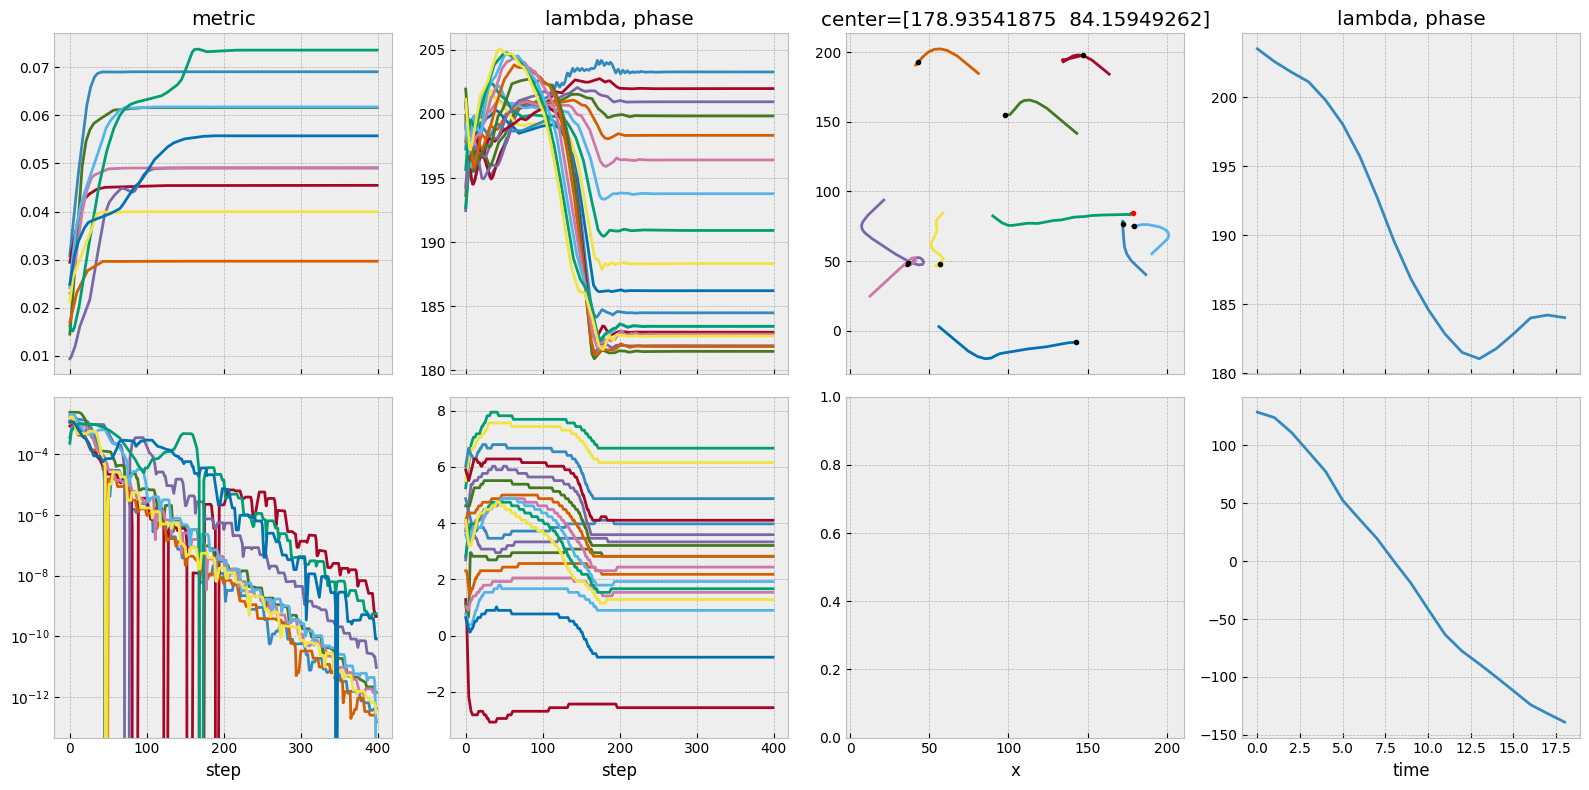

In [155]:
plt.style.use("bmh")
s = 4
fig, ax = plt.subplots(2, 4, figsize=(4*s, 2*s), tight_layout=True, sharex="col")

best_iteration = np.argmax([r["metric"] for r in result_list])
for ii, result in enumerate(result_list):
    ax[0, 0].plot(result["history"]["metric"])
    z = np.array(result["history"]["center"])
    ax[0, 2].plot(z[:, 0], z[:, 1], '-')
    if ii == best_iteration:
        ax[0, 2].plot(z[-1, 0], z[-1, 1], 'r.')
    else:
        ax[0, 2].plot(z[-1, 0], z[-1, 1], 'k.')
    ax[1, 0].semilogy(maximum_filter1d(np.diff(result["history"]["metric"]), 9))

result = result_list[best_iteration]
z = np.array(result["history"]["wavelength"])
ax[0, 1].plot(z, "-")
z = np.unwrap(np.array(result["history"]["phase"]), axis=0)
ax[1, 1].plot(z, "-")
ax[1, 3].plot(result["offset"])
ax[0, 3].plot(result["wavelength"])

ax[0, 0].set_title("metric")
ax[1, 0].set_xlabel("step")
ax[0, 1].set_title("lambda, phase")
ax[1, 1].set_xlabel("step")
ax[0, 2].set_title(f"center={result['history']['center'][-1]}")
ax[1, 2].set_xlabel("x")
ax[0, 3].set_title("lambda, phase")
ax[1, 3].set_xlabel("time")

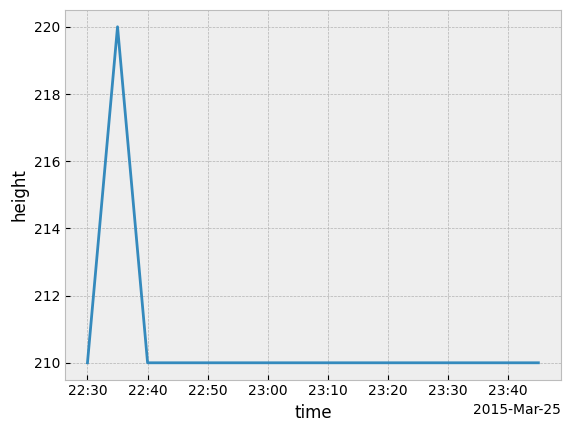

In [118]:
data.height.plot()

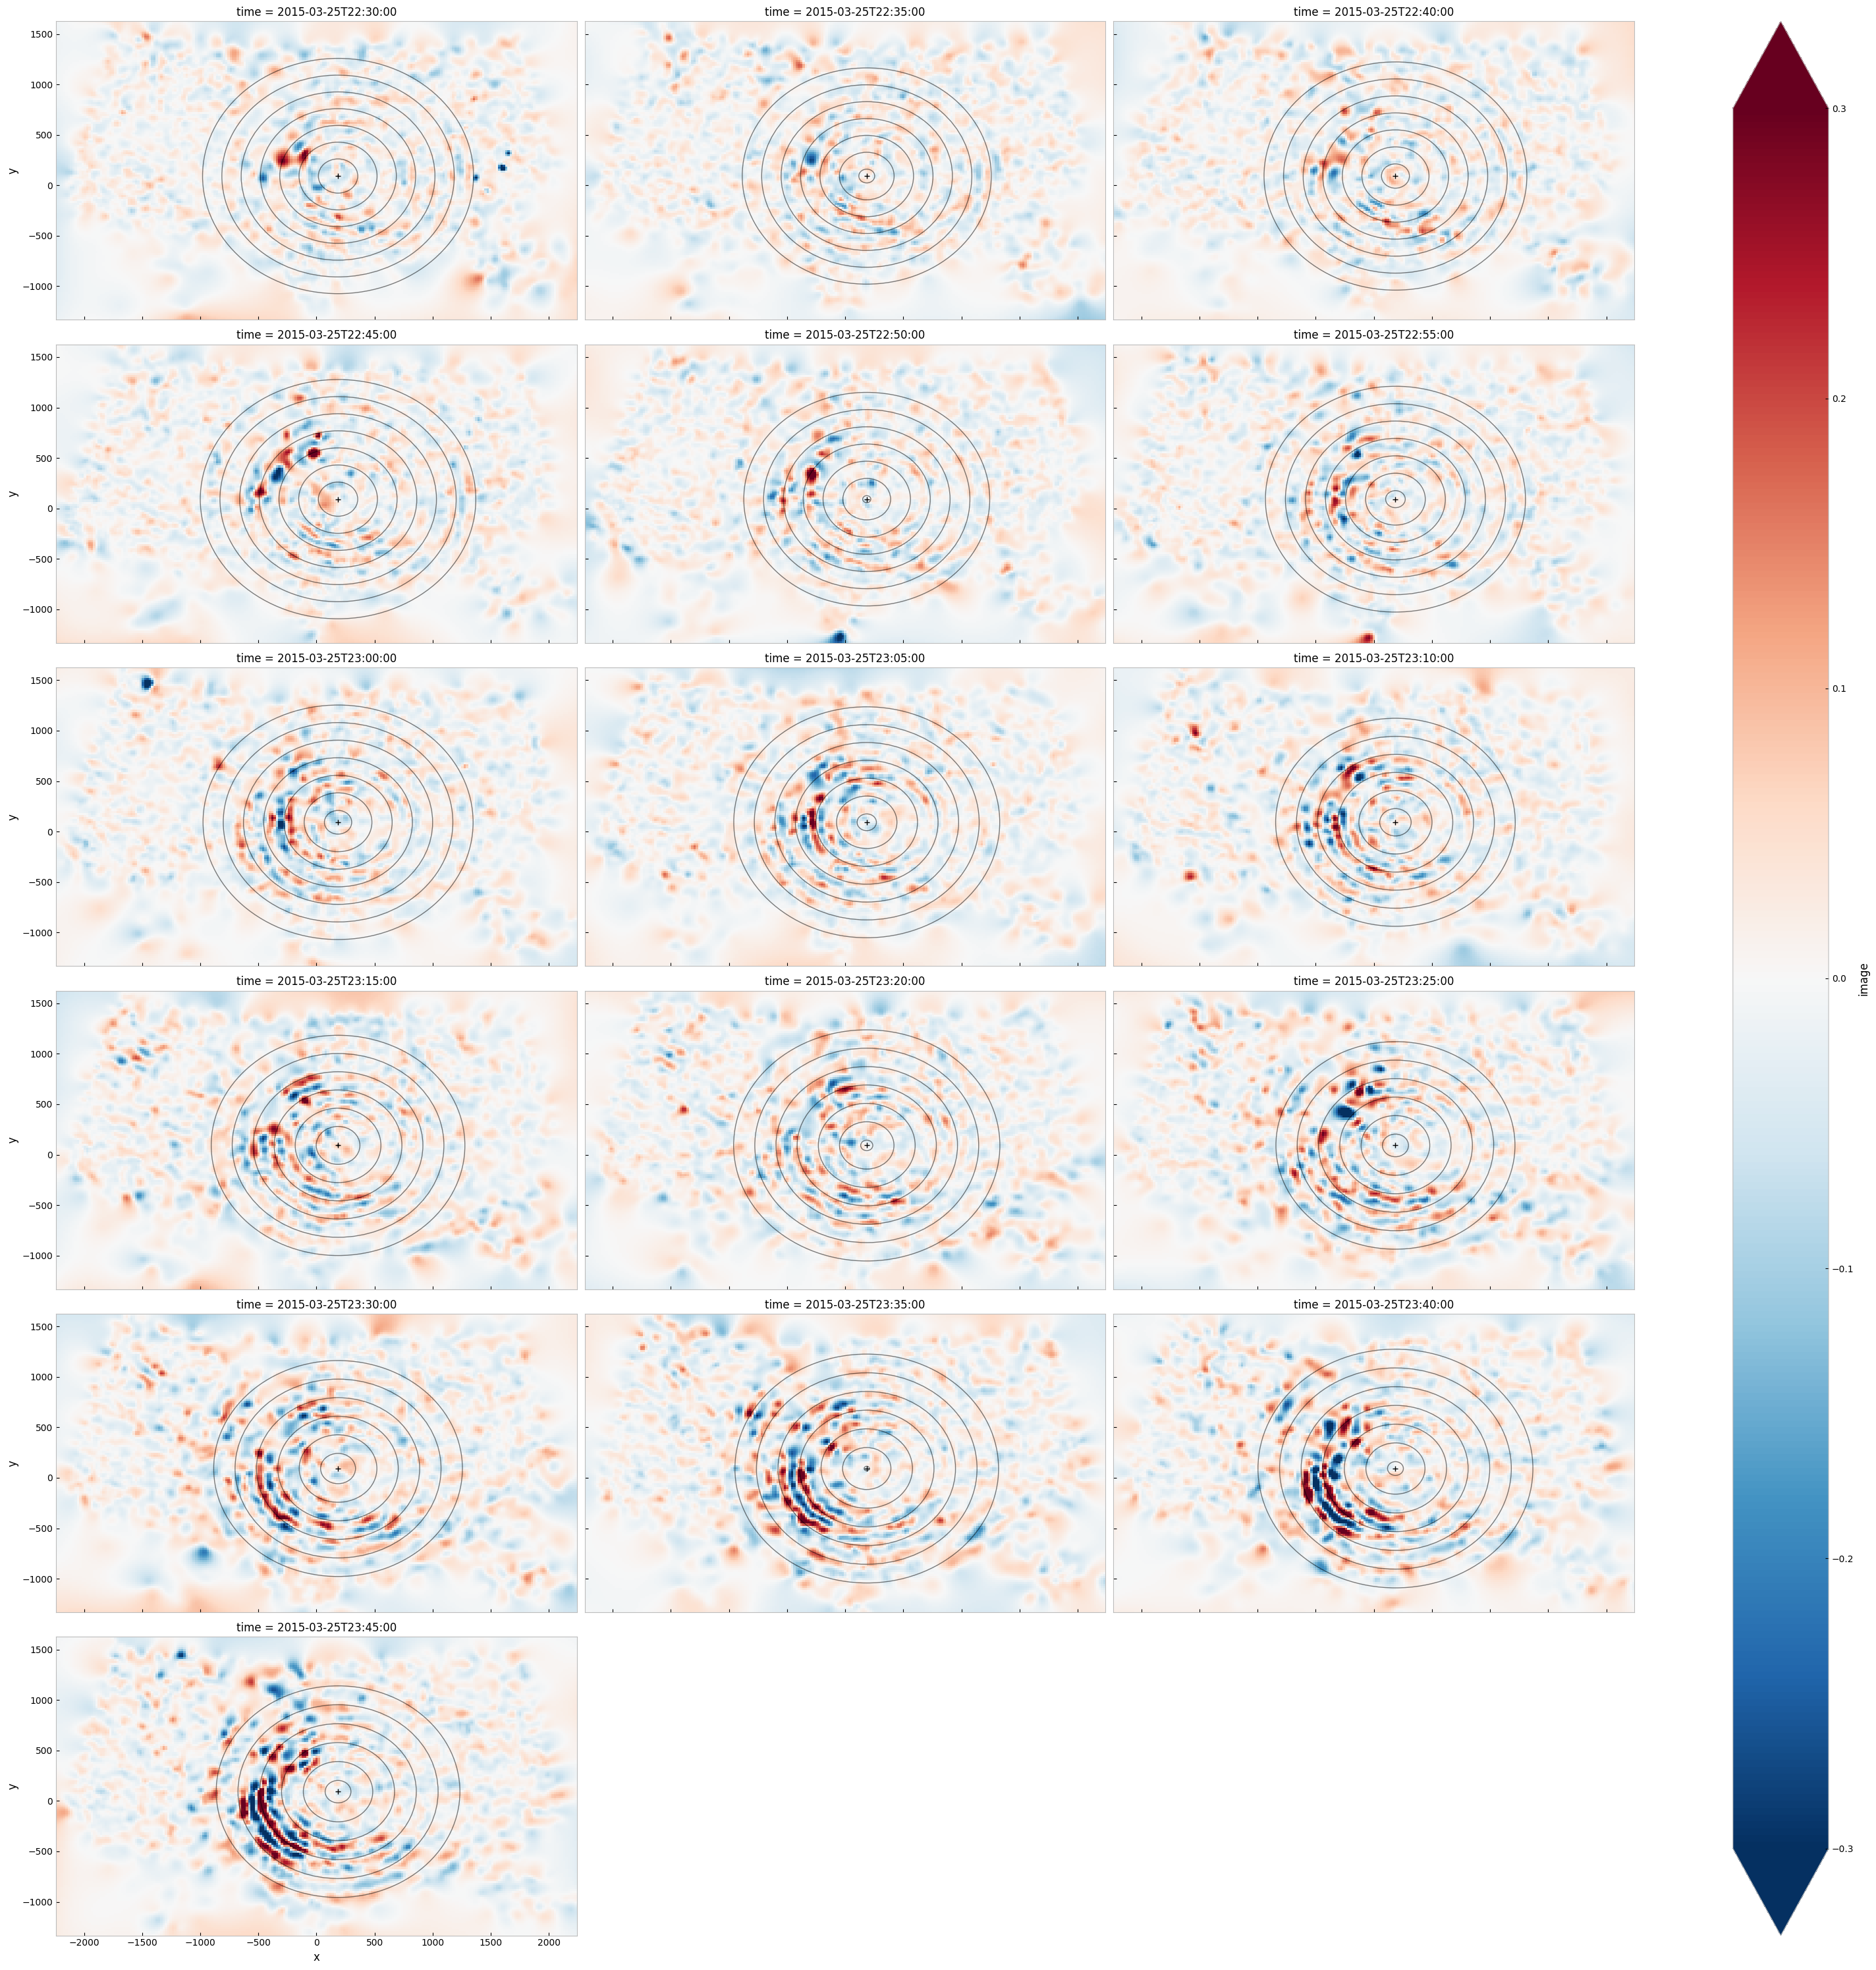

In [101]:
import importlib
importlib.reload(gnss_tid.plotting)

center = result["center"]
wavelength = result["wavelength"]
g = data.image.plot(col="time", col_wrap=3, vmax=.3, size=5, aspect=2)
offset = result["offset"]
for ii in range(len(wavelength)):
    gnss_tid.plotting.plot_circles(center, wavelength[ii], offset[ii], ax=g.axs.flatten()[ii])

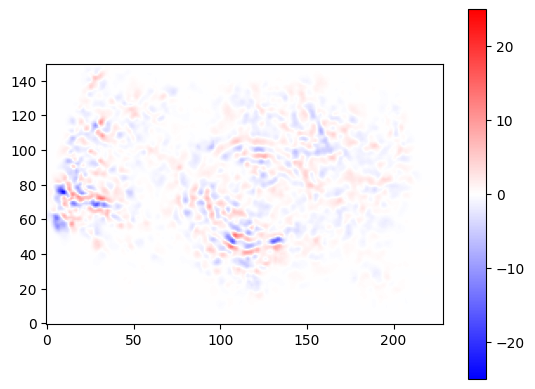

In [66]:
H = nb.sum(axis=1) * data.isel(time=0).image.values.ravel()
H = H.reshape(focuser.image_maker.shape)
im = plt.imshow(H, origin="lower", vmin=-25, vmax=25, cmap="bwr")
plt.colorbar(im)

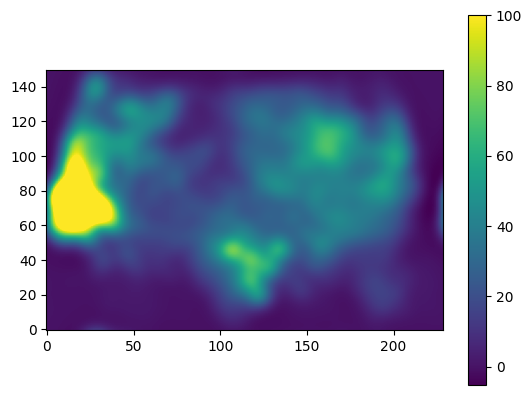

In [68]:
from sklearn.metrics import pairwise_distances
from skimage.filters import butterworth
slices, times = points.get_time_slices(cfg.sample.window, cfg.sample.step)
p = points.get_data(slices[0], 240)
DT = 100
pd = pairwise_distances(focuser.image_maker.points, np.column_stack((p.x, p.y)))
nb = pd < DT
w = nb.sum(axis=1)
w = w.reshape(focuser.image_maker.shape)
w = butterworth(w, .05, high_pass=False)

# w = np.log10(np.exp(-1 * (pd / DT) ** 2).sum(axis=1))

im = plt.imshow(w, origin="lower", vmax=100)
plt.colorbar(im)

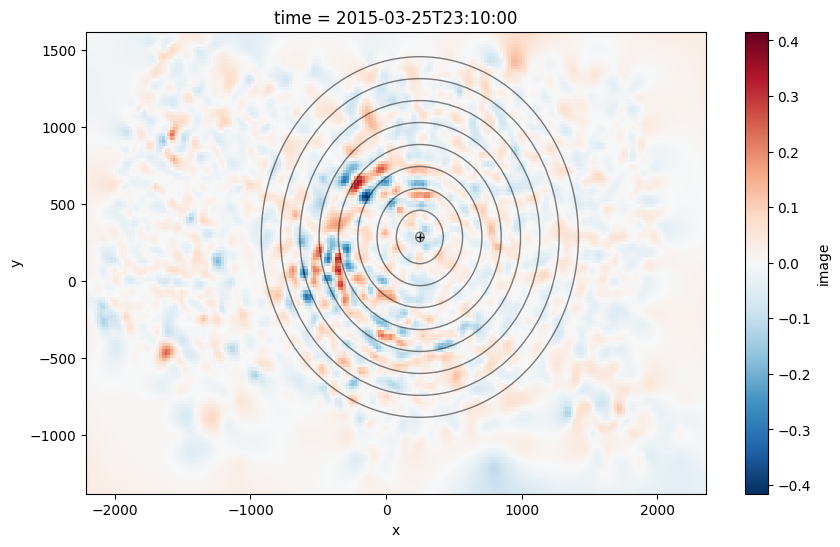

In [13]:
center = [data.isel(time=0).cx.values, data.isel(time=0).cy.values]
wavelength = data.isel(time=0).wavelength.values
offset = data.isel(time=0).offset.values

fig, ax = plt.subplots(1, figsize=(10, 6))
p = points.get_data(slice(0, 4), data.isel(time=0).height.item())
data.isel(time=0).image.plot(ax=ax)
plot_circles(center, wavelength, offset, ax=ax)

(400.0, 1000.0)

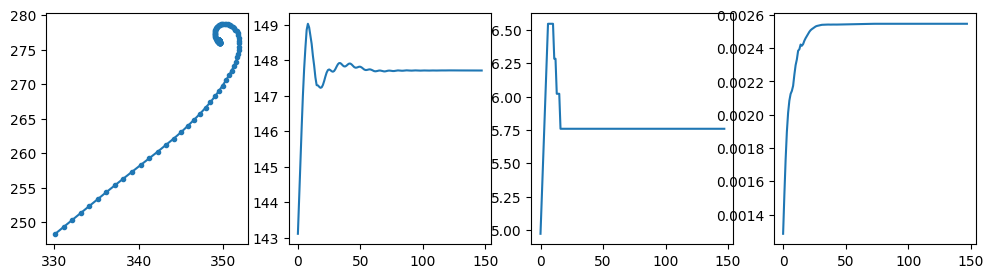

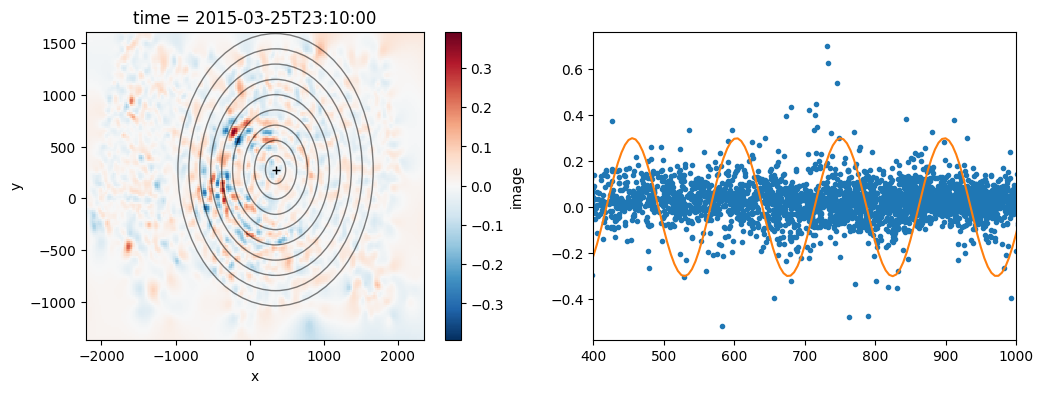

In [4]:

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
z = np.array(result["history"]["center"])
ax[0].plot(z[:, 0], z[:, 1], '.-')
ax[1].plot(result["history"]["wavelength"])
ax[2].plot(np.unwrap(result["history"]["phase"]))
ax[3].plot(result["history"]["metric"])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
p = points.get_data(slice(0, 4), data.isel(time=0).height.item())
data.isel(time=0).image.plot(ax=ax[0])
plot_circles(result["center"], result["wavelength"], result["offset"], ax=ax[0])

r = np.hypot(p.x.values - result["center"][0], p.y.values - result["center"][1])
ax[1].plot(r, p.tec, '.')
rp = np.arange(0, r.max(), 5)
tp = np.cos(2*np.pi*(rp + result["offset"])/result["wavelength"]) * .3
ax[1].plot(rp, tp)
ax[1].set_xlim(400, 1000)


[183.40000726 400.22960846] [281.19436913 287.85620487] [332.56588637 188.04107951]


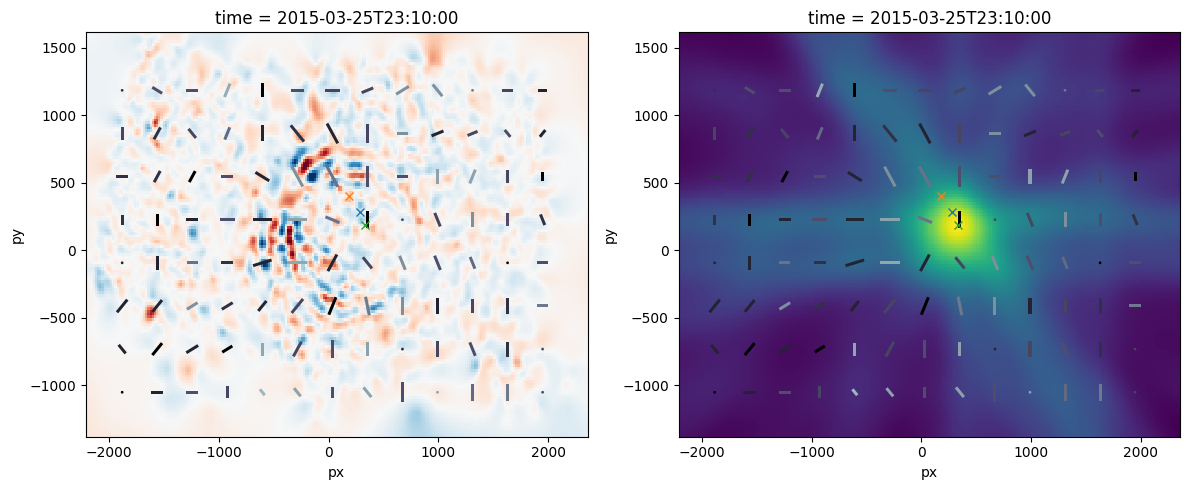

In [2]:
import numpy as np

def find_center(pts, vectors, weights):
    vec_norm = np.linalg.norm(vectors, axis=1)
    mask = vec_norm > 0
    w = np.sqrt(weights[mask]) / vec_norm[mask]
    A = np.column_stack([vectors[mask, 1], -vectors[mask, 0]]) * w[:, None]
    b = np.sum(A * pts[mask], axis=1)
    center, *_ = np.linalg.lstsq(A, b)
    return center

def get_distances(pts, vectors, weights, tp):
    vec_norm = np.linalg.norm(vectors, axis=1)
    mask = vec_norm > 0
    x = tp[:, 0][:, None]
    y = tp[:, 1][:, None]
    x1 = pts[mask, 0][None, :]
    y1 = pts[mask, 1][None, :]
    vx = vectors[mask, 0][None, :]
    vy = vectors[mask, 1][None, :]
    # Numerator: |vx * (y - y1) - vy * (x - x1)|
    numerator = np.abs(vx * (y - y1) - vy * (x - x1))
    # Denominator: sqrt(vx^2 + vy^2)
    denominator = np.sqrt(vx**2 + vy**2)
    # Distance matrix: D[i, j]
    distances = numerator / denominator
    return np.sum(weights[None, mask] * np.exp(-(distances/200)**2), axis=1)
    # return np.sum(weights[None, mask] * distances**2, axis=1)

X, Y = np.meshgrid(data.px.values, data.py.values)
pts = np.column_stack([X.ravel(), Y.ravel()])
weights = data.F.isel(time=0).values.ravel()
vectors = np.column_stack((data.Fx.isel(time=0).values.ravel(), data.Fy.isel(time=0).values.ravel()))
cw = find_center(pts, vectors, weights)
cu = find_center(pts, vectors, np.ones_like(weights))
x, y = np.meshgrid(data.x.values, data.y.values)
xy = np.column_stack([x.ravel(), y.ravel()])
dw = get_distances(pts, vectors, weights, xy).reshape(x.shape)
cg = xy[np.argmax(dw)]

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))
plot_patches(data.isel(time=0), ax=ax[0], img=True)
ax[0].plot(cw[0], cw[1], 'x')
ax[0].plot(cu[0], cu[1], 'x')
ax[0].plot(cg[0], cg[1], 'x')
ax[1].pcolormesh(x, y, dw)
ax[1].plot(cw[0], cw[1], 'x')
ax[1].plot(cu[0], cu[1], 'x')
ax[1].plot(cg[0], cg[1], 'x')
plot_patches(data.isel(time=0), ax=ax[1], img=False)
print(cu, cw, cg)

height = 250
height = 275


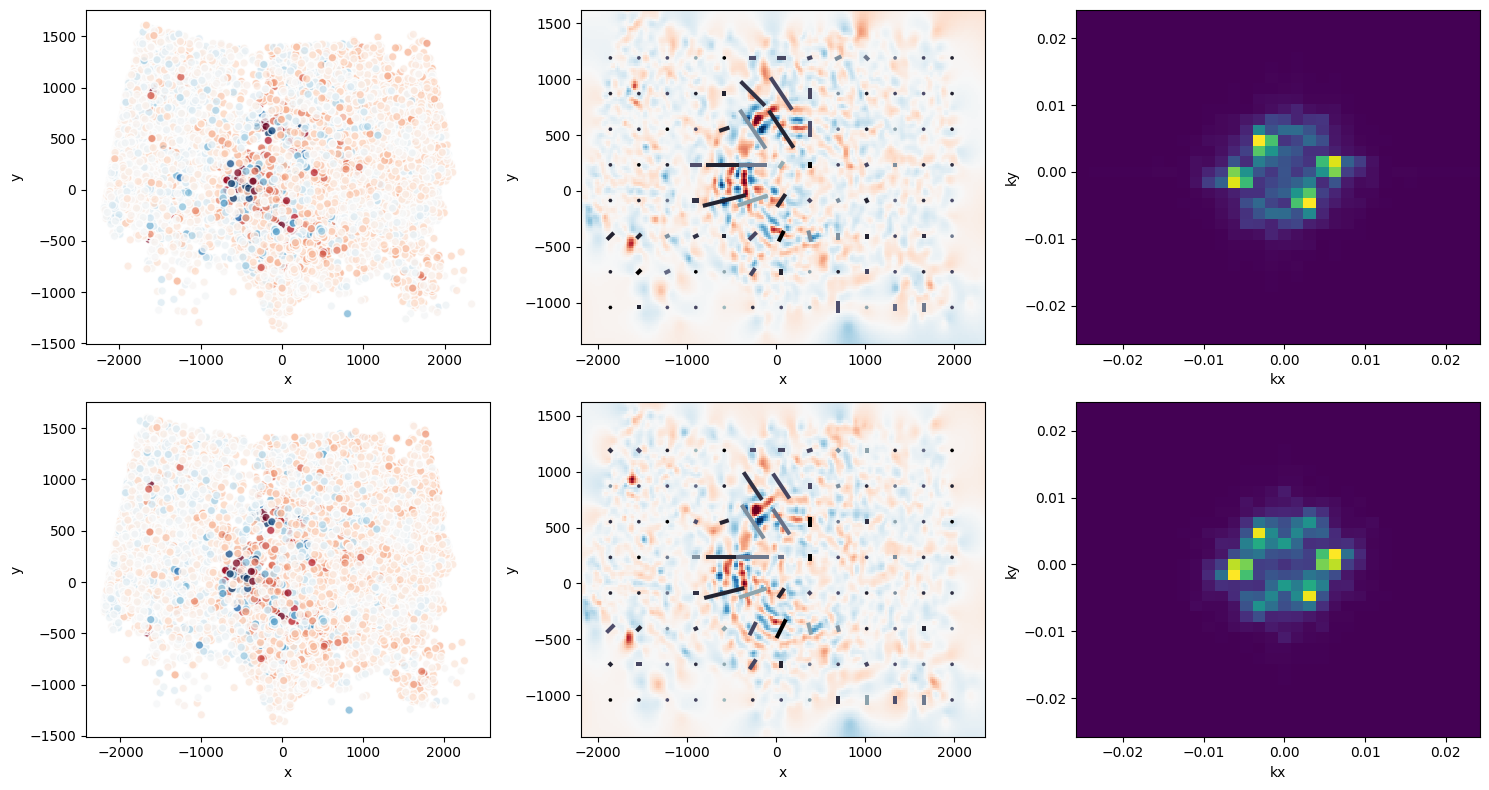

In [27]:
nrows = focuser.heights.shape[0]
if nrows <= 8:
    fig, ax = plt.subplots(nrows, 3, figsize=(15, 4 * nrows), tight_layout=True)
    ax = ax.reshape((nrows, 3))
    B = []
    F = []
    for i, height in enumerate(focuser.heights):
        data = points.get_data(slice(4), height)
        print(f"height = {height}")
        img = focuser.image_maker(data.x.values, data.y.values, data.tec.values)
        patches = focuser.get_fft_patches(img)
        kmax = patches.isel(patches.argmax(dim=["x", "y"])).sortby(["kx", "ky"])
        patchmax = patches.isel(patches.argmax(dim=["kx", "ky"]))
        kmag = np.hypot(patchmax.kx, patchmax.ky)
        kscale = patchmax / kmag.where(lambda x: x > 0, 1)
        ds = xarray.Dataset({
            "F": patchmax,
            "k": kmag,
            "vx": patchmax.kx * kscale,
            "vy": patchmax.ky * kscale,
        }).reset_coords()
        data.plot.scatter(ax=ax[i, 0], x="x", y="y", hue="tec", vmax=.3, alpha=.75, add_colorbar=False)
        # image
        img.plot(ax=ax[i, 1], vmax=.3, add_colorbar=False)
        # directions
        ds.plot.quiver(
            x="x", y="y", u="vx", v="vy", hue="k", ax=ax[i, 1], cmap="bone",
            headwidth=0, headlength=0, headaxislength=0, add_guide=False, 
            scale=5000, width=.01, vmin=0, vmax=.01
        )
        # focus
        kmax.plot(ax=ax[i, 2], add_colorbar=False)
        B.append(patches)
else:
    data = points.get_data(slice(4), focuser.heights[3])
    focuser.image_maker.initialize(data.x.values, data.y.values)
    @delayed
    def func(height):
        data = points.get_data(slice(4), height)
        img = focuser.image_maker(data.x.values, data.y.values, data.tec.values)
        patches = focuser.get_fft_patches(img)
        return patches
    with Parallel(n_jobs=16, verbose=50) as pool:
        B = pool(func(h) for h in focuser.heights)

B = np.stack(B, axis=0)

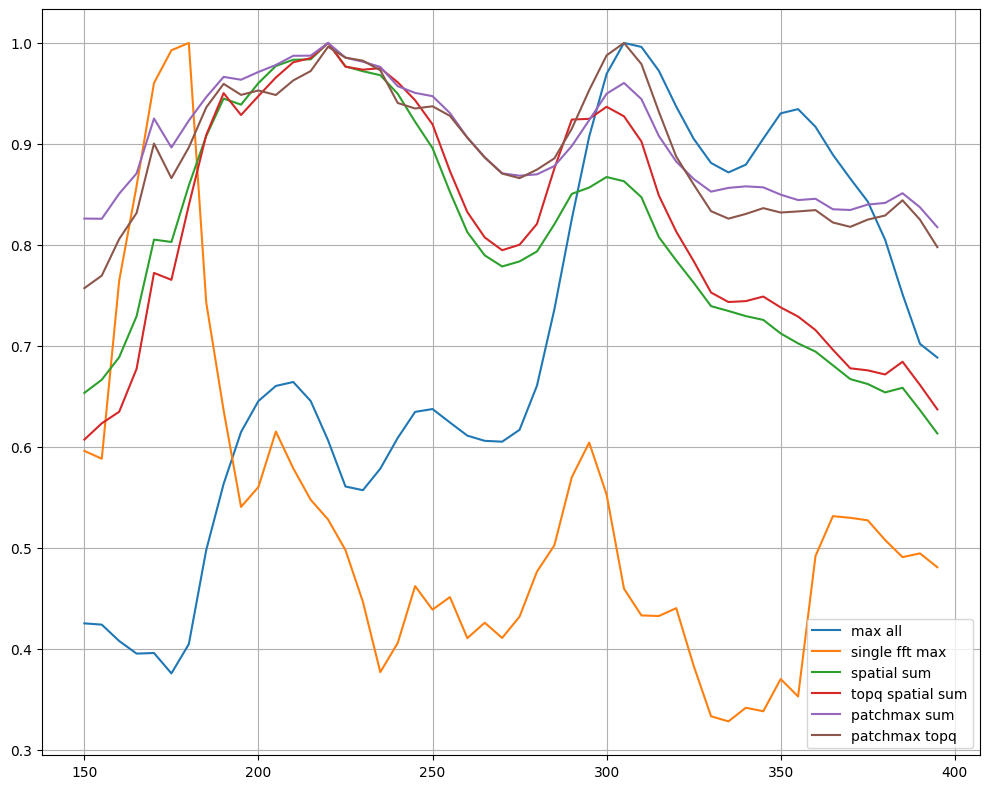

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.grid(True)
ax.plot(focuser.heights, height_max_all / height_max_all.max(), label="max all")
ax.plot(focuser.heights, baseline / baseline.max(), label="single fft max")
ax.plot(focuser.heights, height_sum_space_maxi_freq / height_sum_space_maxi_freq.max(), label="spatial sum")
ax.plot(focuser.heights, height_sum_topq_space_maxi_freq / height_sum_topq_space_maxi_freq.max(), label="topq spatial sum")
ax.plot(focuser.heights, patchmax_sum / patchmax_sum.max(), label="patchmax sum")
ax.plot(focuser.heights, patchmax_topq / patchmax_topq.max(), label="patchmax topq")
ax.legend()

In [ ]:
wavenum = np.fft.fftfreq(focuser.block_shape[0], focuser.image_maker.hres)
patches = (
    data.isel(time=0).image
    .rolling(y=focuser.block_shape[0], x=focuser.block_shape[1], center=True)
    .construct(x="kx", y="ky", stride=focuser.block_step)
    .isel(x=slice(2,-2), y=slice(2,-2))
    .assign_coords(kx=wavenum, ky=wavenum)
    .rename({"x": "px", "y": "py"})
)
patches.values = fft2(patches * focuser.window)


A = patches.sel(kx=data.isel(time=0).Fx, ky=data.isel(time=0).Fy).values.ravel()
k = np.column_stack((data.isel(time=0).Fx.values.ravel(), data.isel(time=0).Fy.values.ravel()))
px, py = np.meshgrid(data.px, data.py)
pxy = np.column_stack((px.ravel(), py.ravel()))
x, y = np.meshgrid(data.x, data.y)
xy = np.column_stack((x.ravel(), y.ravel()))
r = xy[:, None] - pxy[None]
w = np.zeros(A.shape)
wave = np.sum(A * np.exp(1j * np.sum(r * k[None], axis=-1)), axis=1).reshape(x.shape)
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))
plot_patches(data.isel(time=0), ax=ax[0], img=True)
ax[1].pcolormesh(x, y, abs(wave))
plot_patches(data.isel(time=0), ax=ax[1], img=False)

IndexError: Dimensions of indexers mismatch: (slice(None, None, None), slice(None, None, None), <xarray.Variable (py: 8, px: 13)> Size: 832B
array([[ 0,  0,  0,  0, 31, 31,  2, 31,  1,  0,  1,  1,  0],
       [31,  1,  1,  1,  2,  3,  3,  1,  0,  2, 30,  1, 31],
       [ 1,  1,  1,  1,  0,  3,  4, 28,  1,  1,  1,  1,  0],
       [ 0, 31,  0,  0,  1,  0,  3, 31, 30, 30,  1,  0,  0],
       [ 3,  3,  0,  0,  0,  0,  3,  2,  0, 30,  2,  2, 30],
       [ 0,  3,  3,  0, 31, 29, 29,  4,  0,  1,  2,  2,  0],
       [ 0, 29, 30,  2,  2, 30, 29,  4,  0,  1,  1,  3,  1],
       [31, 31,  0,  2,  2,  0,  0,  1,  1, 31,  0,  0,  1]]), <xarray.Variable (py: 8, px: 13)> Size: 832B
array([[0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 1],
       [1, 1, 2, 2, 1, 3, 2, 1, 0, 0, 0, 0, 1],
       [1, 1, 2, 2, 4, 4, 2, 1, 1, 1, 0, 0, 1],
       [3, 0, 1, 2, 4, 4, 2, 0, 0, 1, 0, 0, 1],
       [1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 1],
       [1, 1, 2, 1, 0, 2, 2, 0, 2, 3, 3, 1, 1],
       [1, 1, 2, 1, 0, 2, 2, 3, 2, 1, 0, 1, 0]]))